In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
torch.set_default_dtype(torch.float32)
from flumen import CausalFlowModel,TrunkNet, TrajectoryDataset,CausalFlowModel_spatial
from flumen.utils import pack_model_inputs, plot_amari, trajectory,plot_space_time_flat_trajectory_V2
from torch.utils.data import DataLoader

from generate_data import make_trajectory_sampler

from argparse import ArgumentParser

import yaml
from pathlib import Path
import sys
from pprint import pprint
from time import time
import os
os.chdir("C:/Users/20192139/Documents/5ARG45 - Thesis/Code/FlowFunction/flumen")  # Change this to your actual path
import wandb
import pickle
from flumen import CausalFlowModel, print_gpu_info, TrajectoryDataset, TrunkNet
import torch
import seaborn as sns
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence

In [3]:
def return_model(path,trunk_modes_svd=None):
    api = wandb.Api()
    model_artifact = api.artifact(path)
    model_path = Path(model_artifact.download())
    model_run = model_artifact.logged_by()
#     print(model_run.summary)
    device = "cpu"
    # Load model state dictionary
    with open(model_path / "state_dict.pth", 'rb') as f:
        state_dict = torch.load(f, map_location=torch.device("cpu"))  # Ensure compatibility

    with open(model_path / "metadata.yaml", 'r') as f:
        metadata: dict = yaml.load(f, Loader=yaml.FullLoader)
#     pprint(metadata)
#     print(metadata["args"])
    if trunk_modes_svd != None:
        trunk_model = TrunkNet(in_size=256,out_size=trunk_modes_svd,hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)
        model = CausalFlowModel(**metadata["args"],trunk_model=trunk_model)
    else:
        trunk_model = TrunkNet(in_size=256,out_size=metadata['args']['trunk_modes_svd'],hidden_size=metadata['args']['trunk_size_svd'],use_batch_norm=False)
        model = CausalFlowModel_spatial(**metadata["args"],trunk_model=trunk_model)
        
    model.load_state_dict(state_dict)
    model.eval()
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    return model
device = 'cpu'
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_26836\3190919164.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_

In [66]:

l1_model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
# l1_model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_Innerproduct_50_L1:v36"
l1_model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-B_Innerproduct_100_L1_onlinelearning:v32"
# l1_model_T2500 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_200_L1:v35"
FLOW_model = return_model(l1_model_T2500)
FLOW_model.to(device)

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_25012\3624091777.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_

True
Total trainable parameters: 584851


CausalFlowModel(
  (u_rnn): LSTM(101, 250, batch_first=True)
  (x_dnn): FFNet(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=300, bias=True)
      (1): Tanh()
      (2): Linear(in_features=300, out_features=300, bias=True)
      (3): Tanh()
      (4): Dropout(p=0.1, inplace=False)
      (5): Linear(in_features=300, out_features=150, bias=True)
    )
  )
  (trunk_svd): TrunkNet(
    (layers): ModuleList(
      (0): Linear(in_features=256, out_features=100, bias=True)
      (1): Tanh()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): Tanh()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): Tanh()
      (6): Linear(in_features=100, out_features=100, bias=True)
      (7): Tanh()
      (8): Linear(in_features=100, out_features=100, bias=True)
    )
  )
  (output_NN): FFNet(
    (layers): ModuleList(
      (0): Linear(in_features=100, out_features=0, bias=True)
      (1): Tanh()
      (2): Linear(in_features=0, ou

In [42]:
def compute_quad_weights(x_keep, N_total):
    """
    x_keep: 1D tensor of selected indices (sorted)
    N_total: total number of original spatial points (domain length)
    returns: 1D tensor of weights
    """
    N = len(x_keep)
    weights = torch.zeros_like(x_keep, dtype=torch.float32)

    if N == 1:
        weights[0] = 1.0
    else:
        if N > 2:
            weights[1:-1] = (x_keep[2:] - x_keep[:-2]) / 2
        weights[0] = x_keep[1] - x_keep[0]
        weights[-1] = x_keep[-1] - x_keep[-2]

    # rescale weights to sum to total domain length
    weights = weights * (N_total / weights.sum())
    return weights

def locations_to_keep(N = 100, num_keep = 50):

    candidate_idx = torch.arange(N)  # 0..99

    # randomly select 50 unique indices
    perm = torch.randperm(len(candidate_idx))
    keep_idx = candidate_idx[perm[:num_keep]]
    keep_idx, _ = torch.sort(keep_idx)  # sort indices
    weights = compute_quad_weights(keep_idx,N)  # shape (50,)
    return keep_idx, weights




## Test different training discretizations

In [4]:
test_data = torch.load("data/Brian2/gaussian_test_vs_don_equaltimesteps.pt")
l1_model_x100 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_L1:v54"
l1_model_x75 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-75_v3:v32"
l1_model_x50 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-50_v3:v37"
l1_model_x25 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-25_v3:v39"
l1_model_x100 = return_model(l1_model_x100,trunk_modes_svd=100)
l1_model_x75 = return_model(l1_model_x75)
l1_model_x50 = return_model(l1_model_x50)
l1_model_x25 = return_model(l1_model_x25)
models = [l1_model_x25,l1_model_x50,l1_model_x75]
x_in = (test_data['locations']*100).to(device)
x_out = x_in
all_losses_l1 = []
all_losses_l1_seen_points = []
all_losses_l1_unseen_points = []
for k, model in enumerate(models):
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),x_out,deltas_feed.to(device),x_in)
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    
    losses_flow_total = []
    losses_flow_total_seen_points = []
    losses_flow_total_unseen_points = []
    selected_indices = torch.linspace(0, 99, steps=(k+1)*25).long()
    all_indices = torch.arange(100) 
    mask = ~torch.isin(all_indices, selected_indices)
    other_indices = all_indices[mask]
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
        losses_flow_total_seen_points.append(np.mean(np.abs(y_pred_flow_i[:,selected_indices] - y[:,selected_indices])))
        losses_flow_total_unseen_points.append(np.mean(np.abs(y_pred_flow_i[:,other_indices] - y[:,other_indices])))

#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    all_losses_l1.append(losses_flow_total)
    all_losses_l1_seen_points.append(losses_flow_total_seen_points)
    all_losses_l1_unseen_points.append(losses_flow_total_unseen_points)

    print('l1 all points flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))
    print('l1 seen points flow: ', np.mean(losses_flow_total_seen_points), "std: ", np.std(losses_flow_total_seen_points))
    print('l1 unseen points flow: ', np.mean(losses_flow_total_unseen_points), "std: ", np.std(losses_flow_total_unseen_points))

    
y_pred_flow = []
for i in range(0,len(test_data['x0'])):
    with torch.no_grad():
        x0_feed = test_data['x0'][i]
        t_feed = test_data['t'][i]
        u_feed = test_data['u'][i]
        deltas_feed = test_data['deltas'][i]
        y_pred, basis_functions = l1_model_x100(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
        y_pred_flow.append(y_pred.to('cpu').numpy())

y_pred_flow = np.array(y_pred_flow)      
losses_flow_total = []

# iterate over trajectories
for i in range(len(test_data['y'])):
    y = test_data['y'][i]
    y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
    losses_flow_total.append(np.mean(np.abs(y_pred_flow_i - y))) # L1
#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
losses_flow_total = np.array(losses_flow_total)
all_losses_l1.append(losses_flow_total)
print('l1 flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_26836\2999220445.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  test_data = torch.load("data/Brian2/gaussian_t

True


WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_26836\3190919164.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f, map_location=torch

Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1112251


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1112251


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1159801
l1 all points flow:  0.04844080138044382 std:  0.018154251572295298
l1 seen points flow:  0.03781103584256113 std:  0.019422454556885717
l1 unseen points flow:  0.051984056559738055 std:  0.017850426092323023
l1 all points flow:  0.0368666984751276 std:  0.016210509471059155
l1 seen points flow:  0.035777675700154034 std:  0.01663699630318545
l1 unseen points flow:  0.03795572125010118 std:  0.01591967543714047
l1 all points flow:  0.03796068988354432 std:  0.01848819701261136
l1 seen points flow:  0.03692615703070524 std:  0.01870401290913004
l1 unseen points flow:  0.04106428844206155 std:  0.018258434949889737
l1 flow:  0.036033498551926654 std:  0.019712398313730922


In [5]:
l1_model_x100 = "marijn-eindhoven-university-of-technology/Ablation/flow_model-brian_T2500_S100_LOOP-A_NL_100_MSE:v25"
l1_model_x75 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-75_v3_mse:v21"
l1_model_x50 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-50_v3_mse:v20"
l1_model_x25 = "marijn-eindhoven-university-of-technology/Space_with_offline/flow_model-brian2_gaussian_space-25_v3_mse:v17"
l1_model_x100 = return_model(l1_model_x100,trunk_modes_svd=100)
l1_model_x75 = return_model(l1_model_x75)
l1_model_x50 = return_model(l1_model_x50)
l1_model_x25 = return_model(l1_model_x25)
models = [l1_model_x25,l1_model_x50,l1_model_x75]
x_in = (test_data['locations']*100).to(device)
x_out = x_in
all_losses_mse = []
all_losses_mse_seen_points = []
all_losses_mse_unseen_points = []
pred_y = []
for k, model in enumerate(models):
    model.to(device)
    trajectory_losses = []
    y_pred_flow = []
    for i in range(0,len(test_data['x0'])):
        with torch.no_grad():
            x0_feed = test_data['x0'][i]
            t_feed = test_data['t'][i]
            u_feed = test_data['u'][i]
            deltas_feed = test_data['deltas'][i]
            y_pred, basis_functions = model(x0_feed.to(device), u_feed.to(device),x_out,deltas_feed.to(device),x_in)
            y_pred_flow.append(y_pred.to('cpu').numpy())
    
    y_pred_flow = np.array(y_pred_flow)      
    pred_y.append(y_pred_flow)
    losses_flow_total = []
    losses_flow_total_seen_points = []
    losses_flow_total_unseen_points = []
    selected_indices = torch.linspace(0, 99, steps=(k+1)*25).long()
    all_indices = torch.arange(100) 
    mask = ~torch.isin(all_indices, selected_indices)
    other_indices = all_indices[mask]
    # iterate over trajectories
    for i in range(len(test_data['y'])):
        y = test_data['y'][i]
        y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
        losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
        losses_flow_total_seen_points.append(np.mean((y_pred_flow_i[:,selected_indices] - y[:,selected_indices])**2))
        losses_flow_total_unseen_points.append(np.mean((y_pred_flow_i[:,other_indices] - y[:,other_indices])**2))

#         losses_flow_total.append(np.mean((y_pred_flow_i - y)**2)) # L2
    all_losses_mse.append(losses_flow_total)
    all_losses_mse_seen_points.append(losses_flow_total_seen_points)
    all_losses_mse_unseen_points.append(losses_flow_total_unseen_points)

    print('mse all points flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))
    print('mse seen points flow: ', np.mean(losses_flow_total_seen_points), "std: ", np.std(losses_flow_total_seen_points))
    print('mse unseen points flow: ', np.mean(losses_flow_total_unseen_points), "std: ", np.std(losses_flow_total_unseen_points))

    
y_pred_flow = []
for i in range(0,len(test_data['x0'])):
    with torch.no_grad():
        x0_feed = test_data['x0'][i]
        t_feed = test_data['t'][i]
        u_feed = test_data['u'][i]
        deltas_feed = test_data['deltas'][i]
        y_pred, basis_functions = l1_model_x100(x0_feed.to(device), u_feed.to(device),test_data['locations'].to(device),deltas_feed.to(device))
        y_pred_flow.append(y_pred.to('cpu').numpy())

y_pred_flow = np.array(y_pred_flow)   
pred_y.append(y_pred_flow)
losses_flow_total = []

# iterate over trajectories
for i in range(len(test_data['y'])):
    y = test_data['y'][i]
    y_pred_flow_i = np.flip(y_pred_flow[i], axis=0)
    losses_flow_total.append(np.mean((y_pred_flow_i - y)**2))
losses_flow_total = np.array(losses_flow_total)
all_losses_mse.append(losses_flow_total)
print('mse flow: ', np.mean(losses_flow_total), "std: ", np.std(losses_flow_total))

wandb:   2 of 2 files downloaded.  
WARNING    C:\Users\20192139\AppData\Local\Temp\ipykernel_26836\3190919164.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dic

True
Total trainable parameters: 1066351


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1112251


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1112251


wandb:   2 of 2 files downloaded.  


True
Total trainable parameters: 1112251
mse all points flow:  0.015705765685152067 std:  0.008641310318913747
mse seen points flow:  0.014098222804727924 std:  0.009012494126526743
mse unseen points flow:  0.016241613311960116 std:  0.00859690431753883
mse all points flow:  0.01346979419106903 std:  0.008495447387772508
mse seen points flow:  0.013584483010837025 std:  0.008556911203723124
mse unseen points flow:  0.013355105371301038 std:  0.008509765819739676
mse all points flow:  0.013648917322238465 std:  0.009519218921712244
mse seen points flow:  0.013700350244660969 std:  0.009472706742262216
mse unseen points flow:  0.013494618554970937 std:  0.00984993257032286
mse flow:  0.01261488218115065 std:  0.00882804267637403


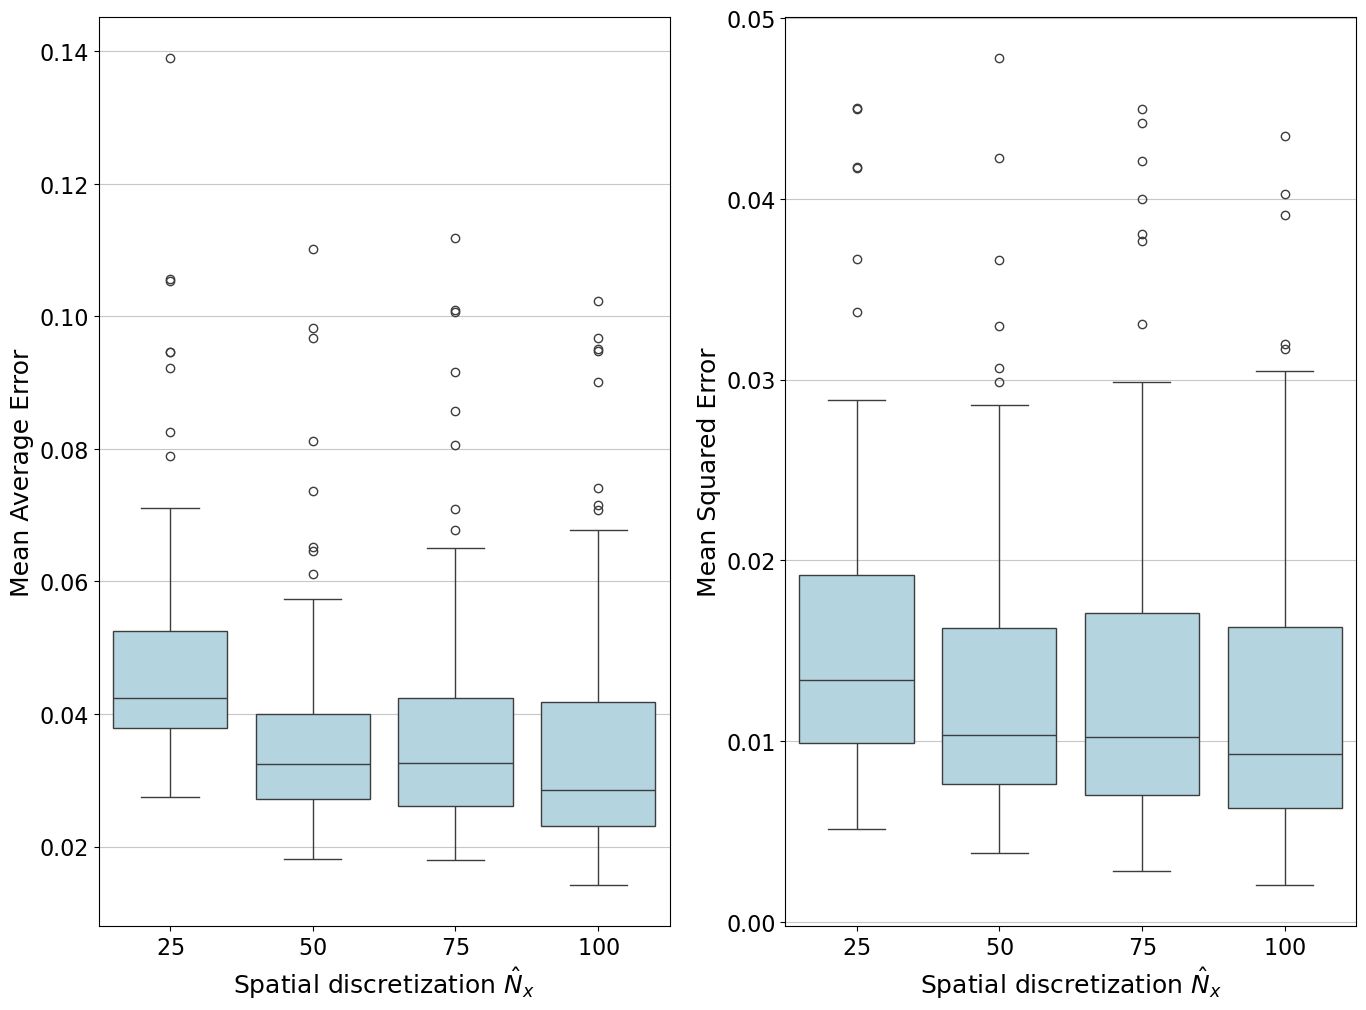

In [7]:
all_losses_x10_l1 = [arr  for arr in all_losses_l1]
all_losses_x10_mse = [arr  for arr in all_losses_mse]
# all_losses_x10_l1 = all_losses_x10_l1[::-1]
# all_losses_x10_mse = all_losses_x10_mse[::-1]

# Number of predictions (for figure height scaling)
n_preds = 1

# Style settings
mpl.rcParams.update({
    'text.usetex': False,
    'axes.titlesize': 18,
    'axes.labelsize': 18,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 20,
    'font.size': 18,
    'axes.grid': True,
    'grid.linestyle': '-',
    'grid.alpha': 0.7,
    'lines.linewidth': 1.5,
    'figure.figsize': [14, 5.5 * (n_preds + 0.9)],  # width fixed, height scales
})

# Example data (scaled by 10)
np.random.seed(0)


# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, sharey=False)  # sharey makes them comparable

# Left subplot
sns.boxplot(data=all_losses_x10_l1, color='lightblue', ax=axes[0])
axes[0].set_xticks(range(4))
axes[0].set_xticklabels([r"$25$", "$50$", "$75$", "$100$"])
axes[0].set_title("")
axes[0].set_ylabel("Mean Average Error")
axes[0].set_xlabel(r"Spatial discretization $\hat{N}_x$")

# Right subplot
sns.boxplot(data=all_losses_x10_mse, color='lightblue', ax=axes[1])
axes[1].set_xticks(range(4))
axes[1].set_xticklabels([r"$25$", "$50$", "$75$", "$100$"])
axes[1].set_title("")
axes[1].set_ylabel("Mean Squared Error")
axes[1].set_xlabel(r"Spatial discretization $\hat{N}_x$")

plt.tight_layout()
plt.show()

In [19]:
# np.savez(
#     "results/flow_differentdiscretizations/gaussian_mse.npz",
#     locations=test_data['locations'].cpu().numpy(),
#     y=test_data['y'],
#     y_pred_x25=pred_y[0],
#     y_pred_x50=pred_y[1],
#     y_pred_x75=pred_y[2],
#     y_pred_x100=pred_y[3],
#     t_feed=t_feed.cpu().numpy()
# )
results = np.load("results/flow_differentdiscretizations/gaussian_mse.npz")


30
(101, 1)
60
(101, 1)
99
(101, 1)


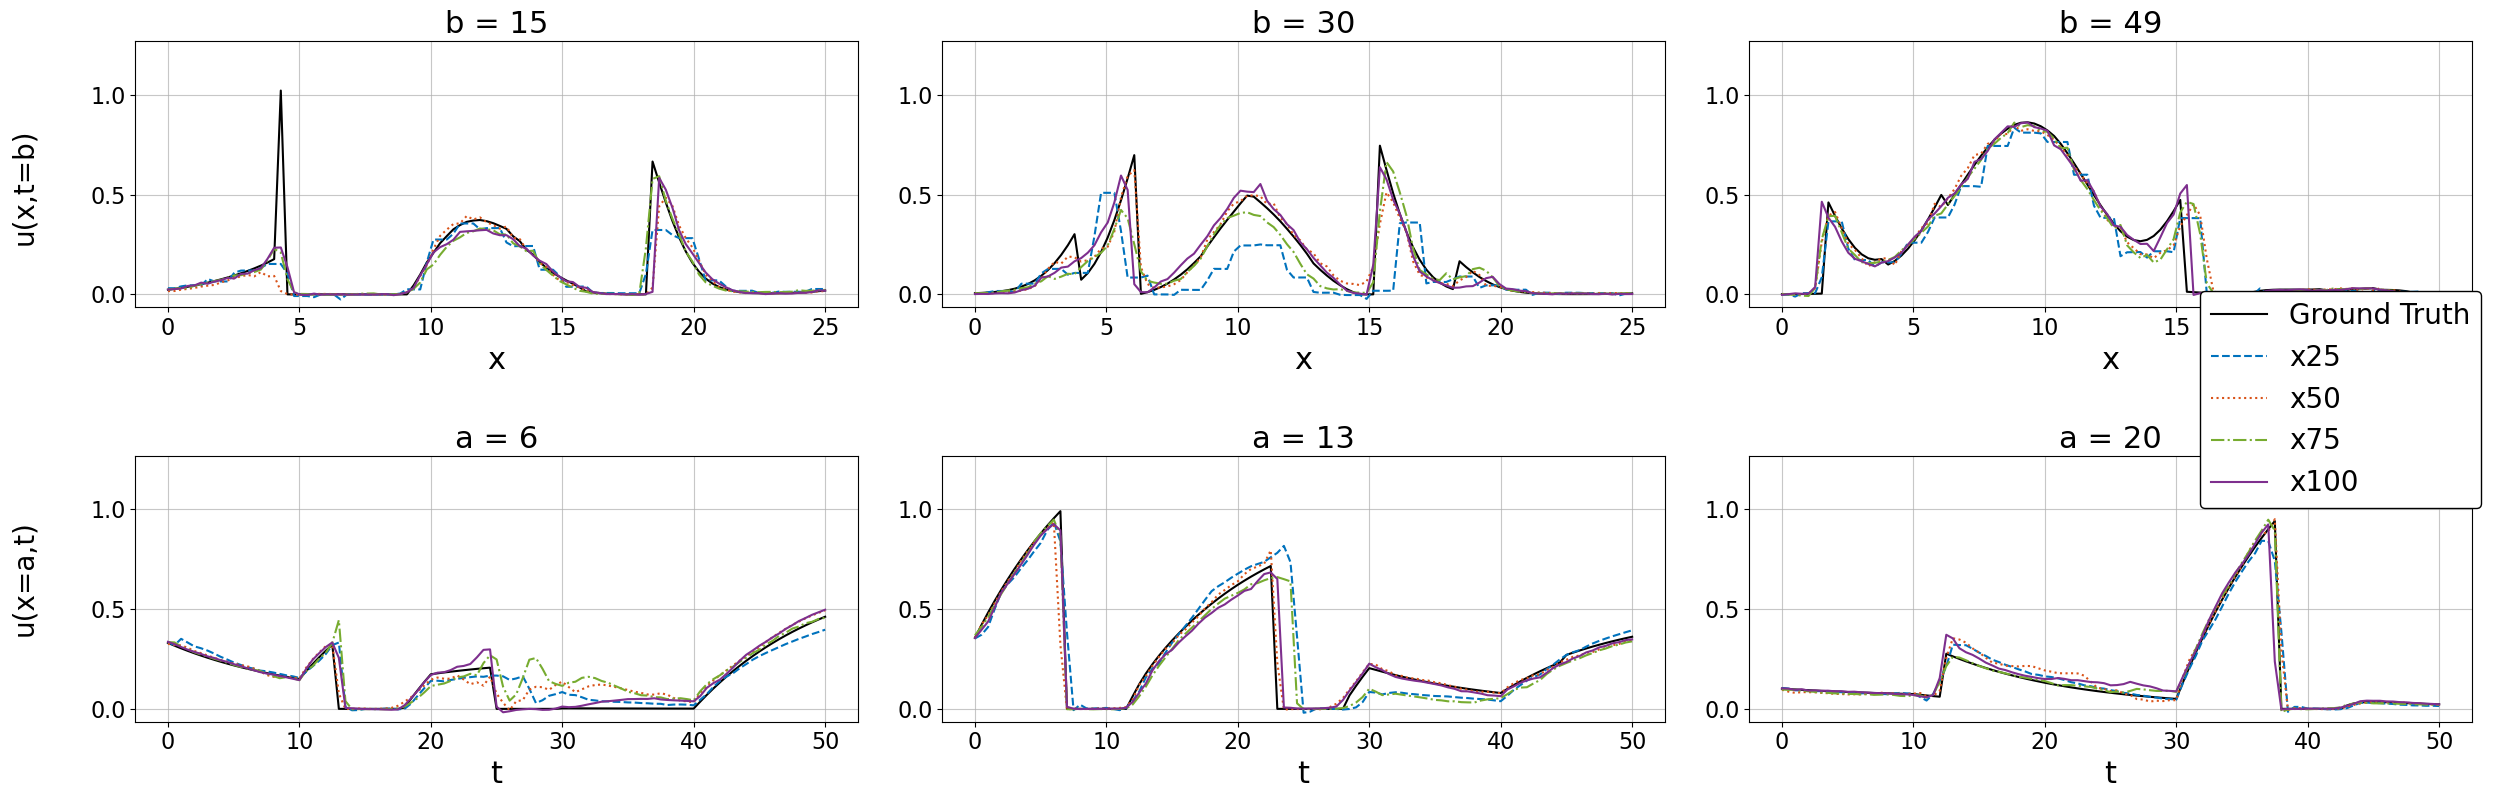

In [38]:
# trajectory = 52
# trajectory = 90
trajectory = 59


# trajectory = 35
fig = plot_trajectory_multiple_trajectories(test_data['y'][trajectory], [pred_y[0][trajectory],pred_y[1][trajectory],pred_y[2][trajectory],pred_y[3][trajectory]],results['t_feed'],labels=["Ground Truth", "x25","x50","x75","x100"],time_indices=[30, 60,99],space_indices=[25, 50, 78,])
plt.show()

In [39]:
trajectory = 59
### DeepOnet needs to be flipped for flipping that happens in plotting fuction
np.savez(
    "plot/data/Discretization/results_59_MSE.npz",
    y_pred_x100 = results['y_pred_x100'][trajectory],
    y_pred_x75 = results['y_pred_x75'][trajectory],
    y_pred_x50 = results['y_pred_x50'][trajectory],
    y_pred_x25 = results['y_pred_x25'][trajectory],

#     y_pred_don= np.flip(results['y_pred_don'][trajectory], axis=0),
#     y_pred_don_ss=np.flip(results['y_pred_don_short_segments'][trajectory], axis=0),
    t_feed=results['t_feed'].reshape(-1,1),
    y=results['y'][trajectory]
)



In [11]:
def plot_trajectory_multiple_trajectories(
    y, y_pred_list, t_feed,
    labels=None,
    time_indices=[61, 120, 181],
    space_indices=[21, 50, 78]
):
    '''
    Args:
        y: Ground truth array of shape (nt, nx)
        y_pred_list: List of prediction arrays, each of shape (nt, nx)
        t_feed: Time array of shape (nt,)
        labels: List of legend labels [ground_truth, pred1, pred2, ...]
    '''
    
    # === Plot style ===
    mpl.rcParams.update({
        'text.usetex': False,
        'axes.titlesize': 22,
        'axes.labelsize': 22,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 20,
        'font.size': 18,
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.7,
        'lines.linewidth': 1.5,
        'figure.figsize': [25, 8.5],  # width x height
    })
    colors = ["black", "#0072BD", "#D95319", "#77AC30", "#7E2F8E"]
    linestyles = ['-', '--', ':', '-.', '-']

    y_np = y.T
    y_pred_np_list = [np.flip(y_pred, axis=0).T for y_pred in y_pred_list]
#     y_pred_np_list = [y_pred.T for y_pred in y_pred_list]
    
    t_feed = np.flip(t_feed)
    all_data = [y_np] + y_pred_np_list
    global_min = min(arr.min() for arr in all_data)
    global_max = max(arr.max() for arr in all_data)

    x = np.linspace(0, 25, y.shape[1])

    n_cols = min(4, len(time_indices))
    n_rows = 2

    fig, axs = plt.subplots(n_rows, n_cols,dpi=100,
                        sharex='row')

    if n_cols == 1:
        axs = axs.reshape(n_rows, 1)

    x = np.linspace(0, 25, y.shape[1])

    for i, t in enumerate(time_indices):
        ax = axs[0, i]
        ax.plot(x, y_np[:, t], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(x, y_pred_np[:, t],
                    label=labels[j + 1] if labels else f"Pred {j+1}",
                    color=colors[(j + 1) % len(colors)],
                    linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        print(t)
        print(t_feed.shape)
        t_feed[t].item()
        ax.set_title(f"b = {t_feed[t].item():.0f}")
        ax.grid(True)
        # Remove individual labels
        ax.set_xlabel('x')
        ax.set_ylabel('')

    for i, idx in enumerate(space_indices):
        ax = axs[1, i]
        ax.plot(t_feed, y_np[idx, :], label=labels[0], color=colors[0], linestyle=linestyles[0])
        for j, y_pred_np in enumerate(y_pred_np_list):
            ax.plot(t_feed, y_pred_np[idx, :],
                    label=labels[j + 1] if labels else f"Pred {j+1}",
                    color=colors[(j + 1) % len(colors)],
                    linestyle=linestyles[(j + 1) % len(linestyles)])
        ax.set_ylim(global_min, global_max)
        ax.set_title(f"a = {x[idx]:.0f}")
        ax.grid(True)
        # Remove individual labels
        ax.set_xlabel('t')
        ax.set_ylabel('')

   
    fig.text(0.01, 0.76,r'u(x,t=b)', va='center', ha='center',
         rotation='vertical', fontsize=20)

    # Second row shared y-axis label
    fig.text(0.01, 0.30, r'u(x=a,t)', va='center', ha='center',
         rotation='vertical', fontsize=20)

#     Add legend as before
    handles, legend_labels = axs[0, 0].get_legend_handles_labels()
    legend = fig.legend(handles, legend_labels,
                        loc='center right',
                        frameon=True,
                        framealpha=1.0,
                        edgecolor='black',
                        facecolor='white',
                        ncol=1)
    legend.set_draggable(True)

    fig.tight_layout(rect=[0.02, 0.02, 1, 1],h_pad=2.0,w_pad=1)  # leave space for labels and legend

    return fig